<a href="https://colab.research.google.com/github/radroid/simple-stock-tracker/blob/main/notebooks/AIDI_1100_GROUP_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simple Stock Tracker Development** 🔻💰 💹

---


In this notebook, we do the following:

* Scan, extract and store last two week's of news from [PR News Wire](https://www.prnewswire.com/news-releases/news-releases-list/) on the following stock:


* Create visualizations


# Coding Section 1: Scan/Parse 

- Scan (the last two weeks or the last week, up to you) from the “newswire” website.
- Parse scanned news.

# Coding Section 2: Search/Track/Store
- Keep track of the news by storing the parsed news - CSV file.
- For all parsed news, search the content of the tracked news to find at least 2-3 stock symbols in a specific industry of your choice; e.g: (TSX: TSLA); (TSX: GM).

## Team Notes
Three functions are created to carry out the tasks described above. 
- Function `page_parse()` scans [PRNewsWire.com](https://www.prnewswire.com/news-releases/news-releases-list/) new release list and returns URLs of scanned articles.
- Function `url_parse()` parses each article and detects any tickers mentioned in the article.
- **Function `run_scanner()` uses the above functions and returns a pandas dataframe containing:**
    - `Articel Date`
    - `Article Title`
    - `Ticker`
    - `Article URL`.

In [1]:
import pandas as pd
import numpy as np
from requests_html import HTMLSession
import requests
import scipy.stats as st
from scipy.stats import ttest_ind_from_stats

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt

get_ipython().run_line_magic('matplotlib', 'inline')
sns.set(color_codes=True)

import pathlib
import os
import time
import random
import math
from statistics import stdev
from datetime import date, timedelta

# keep track of loading progress
from tqdm.notebook import tqdm

In [2]:
# Parse particular news for tickers' mentions
# Takes in an url of an article to pass and an instance of a parsing session from page parser
def url_parse(parse_url, parse_session):
    parse_request = parse_session.get(parse_url)
    content = parse_request.html.find('section.release-body')
    try:
        for item in content:
            parse_ticker = item.find('a.ticket-symbol', first=True).text
    except AttributeError:
        parse_ticker = None
    try:
        return parse_ticker
    except UnboundLocalError:
        return None # Return non if no tickers found

In [3]:
# Function to parse a particular page for all the news to later parse them for tickers.
# Takes 2 parameters: a number of pages and initial dataset of already saved news.
def page_parse(x, page_session, data=[]):
    page_url = f'https://www.prnewswire.com/news-releases/english-releases/?page={x}&pagesize=100'
    page_request = page_session.get(page_url)
    content = page_request.html.find('div.row.arabiclistingcards')
    for item in tqdm(content, desc='Parsing page...\t', leave=False):
        date = item.find('h3', first=True).text.split('ET')[-2]
        title = item.find('h3', first=True).text.split('ET')[-1]
        article_url = 'https://www.prnewswire.com' + item.find('a.newsreleaseconsolidatelink', first=True).attrs['href']
        ticker = url_parse(article_url, page_session)
        try:
            dic = {
              'Date': pd.to_datetime(date),
              'Title': title,
              'Ticker': ticker,
              'Article URL': article_url
            }
            data.append(dic)
        except Exception:
            pass
        
    return data

In [4]:
# Main scanner, takes a number of pages to parse -  default `50` pages.
# `50` pages cover a week of news
# `100` pages cover 2 weeks of data.
def run_scanner(pages=10):
    session = HTMLSession()
    data = []

    for x in tqdm(range(1, pages+1), desc='Loading Pages...\t'):
        page_parse(x, session, data)
    
    df = pd.DataFrame(data)
    # df['Ticker'] = df['Ticker'].dropna()
    df.set_index('Date', inplace=True)
    return df

In [5]:
t0 = time.time()
df = run_scanner(10)
print(f'Time Taken: {(time.time() - t0): .1f}s')

Loading Pages...	:   0%|          | 0/10 [00:00<?, ?it/s]

Parsing page...	:   0%|          | 0/100 [00:00<?, ?it/s]

Parsing page...	:   0%|          | 0/100 [00:00<?, ?it/s]

Parsing page...	:   0%|          | 0/100 [00:00<?, ?it/s]

Parsing page...	:   0%|          | 0/100 [00:00<?, ?it/s]

Parsing page...	:   0%|          | 0/100 [00:00<?, ?it/s]

Parsing page...	:   0%|          | 0/100 [00:00<?, ?it/s]

Parsing page...	:   0%|          | 0/100 [00:00<?, ?it/s]

Parsing page...	:   0%|          | 0/100 [00:00<?, ?it/s]

Parsing page...	:   0%|          | 0/100 [00:00<?, ?it/s]

Parsing page...	:   0%|          | 0/100 [00:00<?, ?it/s]

Time Taken:  170.1s


In [8]:
df.dropna(subset=['Ticker']).isna().sum()

Title          0
Ticker         0
Article URL    0
dtype: int64

In [9]:
df2 = df.dropna(subset=['Ticker'])

# Saving the file
In this section we will save the Pandas DataFrame created above.

In [10]:
# create filename using the first and last dates.
sorted_df = df.sort_values('Date')

start_date = sorted_df.index[0].date()
end_date = sorted_df.sort_values('Date').index[-1].date()

# concate dates to create name for the CSV file.
filename = start_date.strftime('%d%b%y') + '-to-' + end_date.strftime('%d%b%y') + '.csv'
print(filename)

16Nov21-to-16Nov21.csv


In [11]:
data_dir = pathlib.Path('/content/datasets/')

if not data_dir.exists():
    os.mkdir(data_dir)

# Save dataframe as a csv for further analysis
df.to_csv(data_dir / filename) 
print(f'CSV file saved to: {data_dir / filename}')

CSV file saved to: /content/datasets/16Nov21-to-16Nov21.csv


# Coding Section 3: Retrieve Data (Web (API))
- Scan `Yahoo! Finance` page for the stock symbols that appeared in the news (there should be a module for yahoo finance that you can use instead of looking for webpage content). </br>
- Capture/retrieve the `stock price` and `volume` for `last 30 days`.

In [12]:
# install and/or load yfinance module
try:
    success_msg = '\n\nYahoo! Finance module loaded.'
    import yfinance as yf
    print(success_msg)
except ModuleNotFoundError as e:
    print('Installing Yahoo! Finance python module...')
    !pip install yfinance
    import yfinance as yf
    print(success_msg)



Yahoo! Finance module loaded.


## Global variables

In [13]:
csv_file_path = data_dir / filename
output_stock_dump_path = data_dir / 'stock_data/'

## Retrieve the previously stored csv with the news and ticker

In [14]:
df = pd.read_csv(csv_file_path)
df

,Date,Title,Ticker,Article URL
0,2021-11-16 17:54:00,Brooks Automation Announces Planned Name and ...,NaN,https://www.prnewswire.com/news-releases/brook...
1,2021-11-16 17:50:00,Premise Data Launches Proactive Program to En...,NaN,https://www.prnewswire.com/news-releases/premi...
2,2021-11-16 17:49:00,"Following State Of Emergency Declaration, Fam...",NaN,https://www.prnewswire.com/news-releases/follo...
3,2021-11-16 17:46:00,LAMF Global Ventures Corp. I Announces Comple...,NaN,https://www.prnewswire.com/news-releases/lamf-...
4,2021-11-16 17:46:00,Evolent Health to Host Oncology Care Panel on...,EVH,https://www.prnewswire.com/news-releases/evole...
...,...,...,...,...
986,2021-11-16 08:00:00,J.P. Morgan Asset Management Taps the firm's ...,JPM,https://www.prnewswire.com/news-releases/jp-mo...
987,2021-11-16 08:00:00,Quantum ActiveScale Object Storage Achieves A...,QMCO,https://www.prnewswire.com/news-releases/quant...
988,2021-11-16 08:00:00,BioMagnetic Solutions Confirms ISO Certificat...,NaN,https://www.prnewswire.com/news-releases/bioma...
989,2021-11-16 08:00:00,FICO Launches Powerful Next-Generation Origin...,FICO,https://www.prnewswire.com/news-releases/fico-...


## Call the Yahoo finance API and get the parsed stock values for every stock from the previously loaded csv


In [15]:
def get_stock_quotes(ticker: str, period: str = "30d"):

    if type(ticker) is not str:
        return

    # Get the stock data of this ticker
    stock_data = yf.Ticker(ticker)

    # get historical market data of the past 30 days
    return stock_data.history(period=period)

In [16]:
#@title # Tickers and dates of interest
#@markdown Enter
#@markdown - **Number** of top tickers
#@markdown - **Name** of the tickers (comma separated)

#@markdown you would like to consider:
top_tickers = "3" #@param ["10", "5", "3", "1", "PANW,BTCM,CIT"] {allow-input: true}

#@markdown Enter the number of past days to consider:
num_of_days = 30 #@param {type:"slider", min:0, max:100, step:1, default:30}
period = str(num_of_days) + 'd'


def is_float(string: str) -> bool:
    try:
        float(string)
        return True
    except ValueError as e:
        print('Not a float.')
        return False


if top_tickers.isnumeric():
    number = int(top_tickers)
    top_tickers2 = list(df.Ticker.value_counts().iloc[:number].index)
    print(top_tickers2)
elif not is_float(top_tickers):
    top_tickers2 = top_tickers.split(',')
    print(top_tickers2)
else:
    print('Invalid input. Please enter a valid input.')



['PANW', 'SSNC', 'BK']


In [27]:
# Create an empty folder
if not output_stock_dump_path.exists():
    os.mkdir(output_stock_dump_path)

stock_names = []

for ticker in tqdm(df.Ticker, desc='Getting Stocks data... \t'):
    # Get the stock performance data for the past 30 days of this stock
    if not ticker in top_tickers2:
        continue

    stock_data = get_stock_quotes(ticker, period)
    
    if stock_data is None:
        continue
    
    stock_df = pd.DataFrame(
        {
            'Date': stock_data.Volume.keys(),
            'Open': stock_data.Open.values,
            'Close': stock_data.Close.values,
            'Low': stock_data.Low.values,
            'High': stock_data.High.values,
            'Volume': stock_data.Volume.values,
        }
    )
    stock_names += ticker
    stock_df.to_csv(output_stock_dump_path / (ticker+'.csv'), index=False)

print(f'The data of the following stocks was saved to {output_stock_dump_path}:')
print(f'{top_tickers2}')

Getting Stocks data... 	:   0%|          | 0/991 [00:00<?, ?it/s]

The data of the following stocks was saved to /content/datasets/stock_data:
['PANW', 'SSNC', 'BK']


# Visualization


In [43]:
# Read CSV files 
stocks_df = {ticker: pd.read_csv(output_stock_dump_path / (ticker+'.csv'))
             for ticker in top_tickers2}
print("\n".join(list(stocks_df.keys())))

PANW
SSNC
BK


In [64]:
#@markdown Enter the name of ticker you would like to visualize:
ticker = "PANW" #@param {type:"string"}
#@markdown > **Note**: Choose from one of the tickers listed above this cell.

ticker = ticker.strip().upper()

# check if input is valid
if stocks_df.get(ticker) is None:
    raise ValueError('Please enter a valid Ticker value.')


In [62]:
# view top 5 rows of the ticker
print(f'Top 5 rows of {ticker}.\n')
stocks_df.get(ticker).head()

Top 5 rows of PANW.



,Date,Open,Close,Low,High,Volume
0,2021-10-06,473.269989,486.130005,472.929993,487.989990,920800
1,2021-10-07,487.619995,493.679993,487.420013,502.220001,1281900
2,2021-10-08,494.000000,492.790009,490.640015,500.559998,778800
3,2021-10-11,492.109985,499.809998,488.100006,501.609985,728800
4,2021-10-12,503.000000,505.239990,501.279999,510.000000,1210100


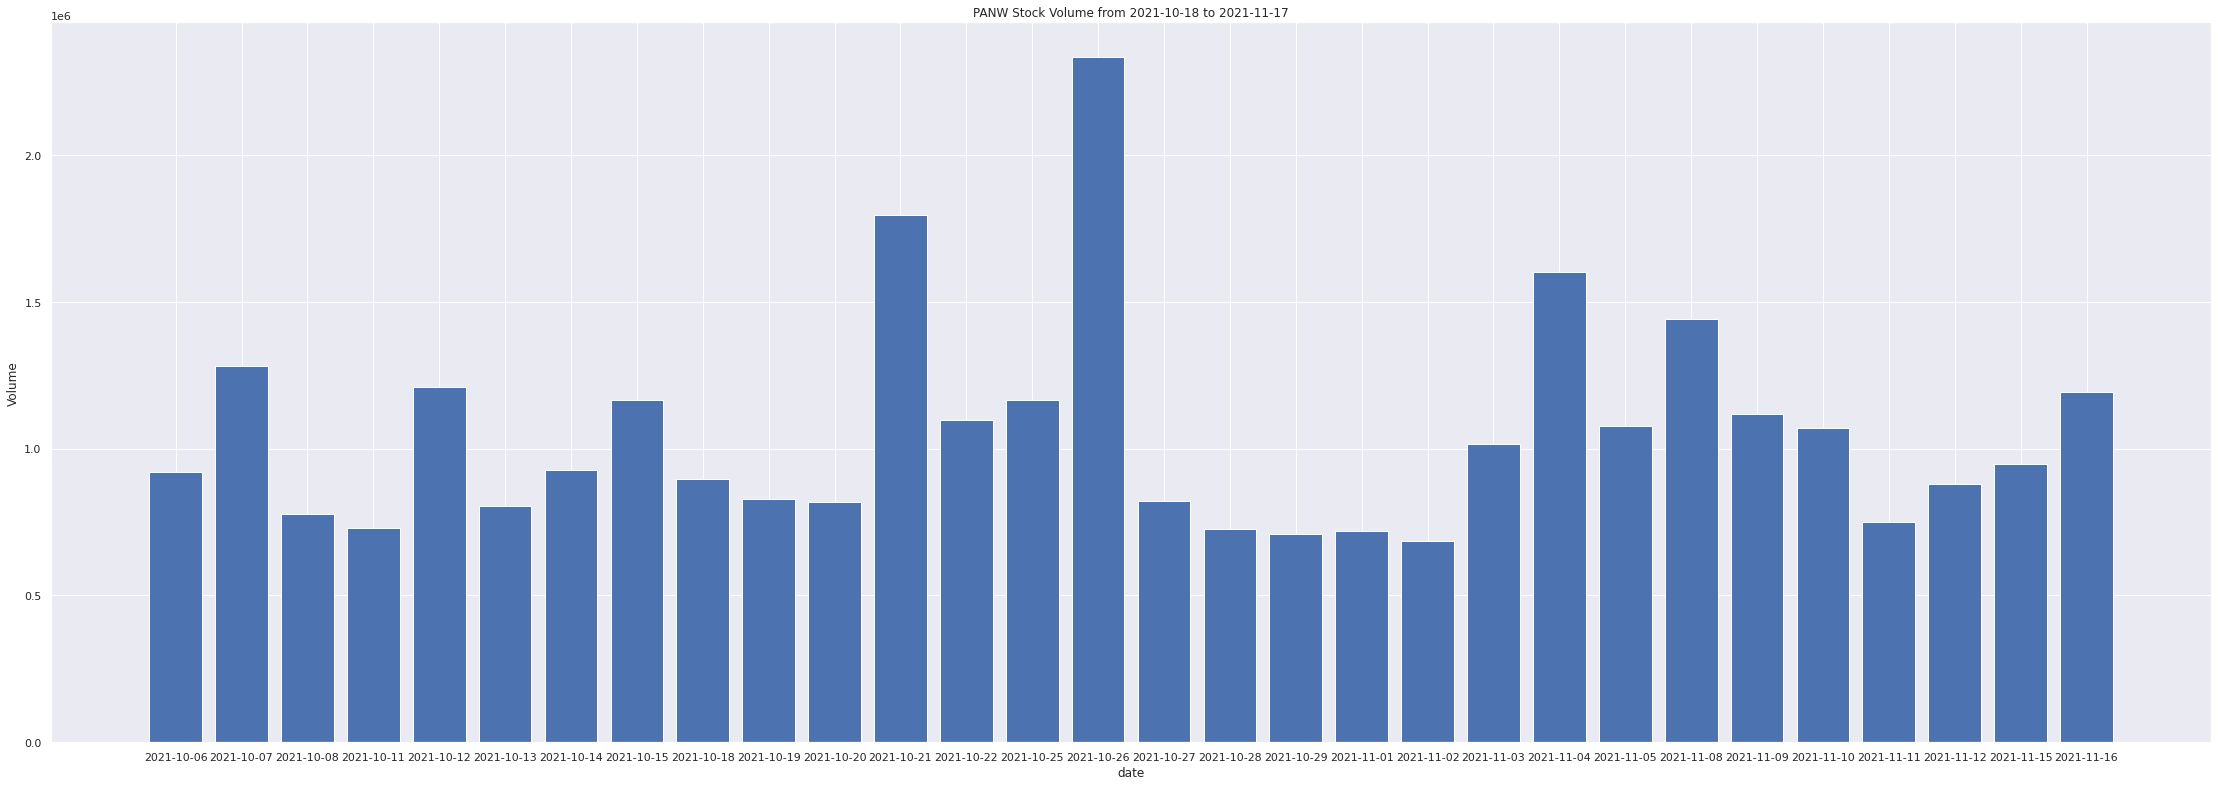

In [69]:
current_date = date.today().isoformat()   
days_before = (date.today()-timedelta(days=30)).isoformat()
fig = plt.figure(figsize=(30,10))
ax = fig.add_axes([0,0,1,1])
volum = stocks_df.get(ticker)['Volume']
days= stocks_df.get(ticker)['Date']
ax.bar(days,volum)
plt.xlabel("date")
plt.ylabel("Volume")
plt.title(f"{ticker} Stock Volume from "+ days_before +" to " + current_date )
plt.show()

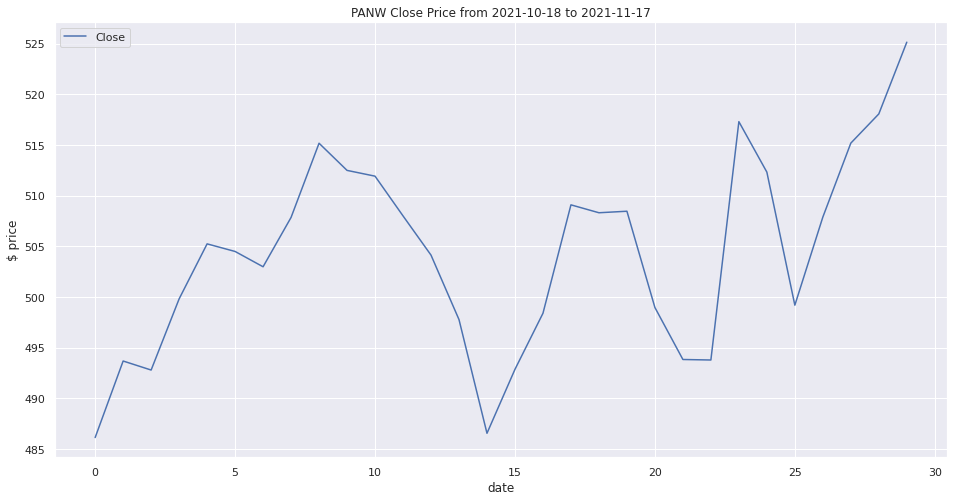

In [68]:
stocks_df.get(ticker)[['Close']].plot(label=ticker,figsize=(16,8),title='ClosePrice')
plt.legend()
plt.xlabel("date")
plt.ylabel("$ price")
plt.title(f"{ticker} Close Price from "+ days_before +" to " + current_date )
 
plt.show()